# LIMEtree Tabular Experiments

In [1]:
import joblib
import logging
import pickle

import numpy as np

import sklearn.datasets as skl_data
import sklearn.linear_model as skl_lm
import sklearn.metrics as skl_metrics
import sklearn.model_selection as skl_tts

from scripts.limetree import (
    logger,
    explain_tabular,
    process_loss, summarise_loss_lime, summarise_loss_limet,
    plot_loss_summary, tabulate_loss_summary)

24-Apr-28 22:31:45 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


In [2]:
! mkdir -p _figures

# logging.basicConfig(level=logging.DEBUG)
logger.setLevel(logging.DEBUG)

%matplotlib inline

# Model and Data

In [3]:
# *wine recognition* data set
data_wine = skl_data.load_wine(return_X_y=True)[0]
labels_wine = skl_data.load_wine(return_X_y=True)[1]

wine_split = skl_tts.train_test_split(
    data_wine, labels_wine, train_size=0.8, random_state=42, stratify=labels_wine)
data_wine_train, data_wine_test, labels_wine_train, labels_wine_test = wine_split

clf_wine_name = 'clf_wine_lr-exp.joblib'
results_wine_name = 'limet_wine_sample.pickle'

X, Y = data_wine, labels_wine
X_train, Y_train = data_wine_train, labels_wine_train
X_test, Y_test = data_wine_test, labels_wine_test

clf_name = clf_wine_name

kernel_width = 25

In [4]:
clf_wine_lr = skl_lm.LogisticRegression(
    random_state=42,
    solver='lbfgs', multi_class='multinomial', max_iter=10000)
clf = clf_wine_lr

clf.fit(X_train, Y_train)

Y_test_predicted = clf.predict(X_test)
_bacc = skl_metrics.balanced_accuracy_score(Y_test, Y_test_predicted)
print(f"Model's performance (balanced accuracy): {_bacc:0.3f}")

joblib.dump(clf, clf_name)

Model's performance (balanced accuracy): 0.933


['clf_wine_lr-exp.joblib']

## Test Processing Instances

In [5]:
id_x = 0
instance_id, top_pred, similarities, lime, limet = explain_tabular(
    X_test[id_x, :], id_x, clf, X, Y,
    random_seed=42, n_top_classes=3,
    samples_number=10000, batch_size=100,  # Processing
    kernel_width=kernel_width)             # Similarity

24-Apr-28 22:31:49 scripts.limetree DEBUG    Instance: 0
24-Apr-28 22:31:49 scripts.limetree DEBUG    Instance: 0
24-Apr-28 22:31:49 scripts.limetree DEBUG    Top n classes: 3
24-Apr-28 22:31:49 scripts.limetree DEBUG    Top n classes: 3
24-Apr-28 22:31:49 fatf         INFO     Seeding RNGs using the input parameter.
24-Apr-28 22:31:49 fatf         INFO     Seeding RNGs with 42.
24-Apr-28 22:31:49 scripts.limetree DEBUG    Sampled data shape: (10000, 13)
24-Apr-28 22:31:49 scripts.limetree DEBUG    Sampled data shape: (10000, 13)
24-Apr-28 22:31:49 scripts.limetree DEBUG    Sampled data predicted class ratio: {0: 6142, 1: 2198, 2: 1660}
24-Apr-28 22:31:49 scripts.limetree DEBUG    Sampled data predicted class ratio: {0: 6142, 1: 2198, 2: 1660}
24-Apr-28 22:31:49 scripts.limetree DEBUG    33.50% of similarities is 0.
24-Apr-28 22:31:49 scripts.limetree DEBUG    33.50% of similarities is 0.


In [6]:
assert instance_id == id_x, 'Expected the dame ID'
assert np.array_equal(top_pred, [0, 2, 1]), 'Expect correct predictions'

## Run Sample Processor

In [7]:
id_xs = 5
collector = {}
for i, (x, _y) in enumerate(zip(X_test[:id_xs, :], Y_test[:id_xs])):
    instance_id, top_pred, similarities, lime, limet = explain_tabular(
        x, i, clf, X, Y,
        random_seed=42, n_top_classes=3,
        samples_number=10000, batch_size=100,  # Processing
        kernel_width=kernel_width)             # Similarity
    assert instance_id == i
    collector[instance_id] = (top_pred, similarities, lime, limet)
    logger.debug(f'Progress: {100*(i+1)/id_xs:3.0f}% [{i+1} / {id_xs}]')

24-Apr-28 22:31:52 scripts.limetree DEBUG    Instance: 0
24-Apr-28 22:31:52 scripts.limetree DEBUG    Instance: 0
24-Apr-28 22:31:52 scripts.limetree DEBUG    Top n classes: 3
24-Apr-28 22:31:52 scripts.limetree DEBUG    Top n classes: 3
24-Apr-28 22:31:52 fatf         INFO     Seeding RNGs using the input parameter.
24-Apr-28 22:31:52 fatf         INFO     Seeding RNGs with 42.
24-Apr-28 22:31:52 scripts.limetree DEBUG    Sampled data shape: (10000, 13)
24-Apr-28 22:31:52 scripts.limetree DEBUG    Sampled data shape: (10000, 13)
24-Apr-28 22:31:52 scripts.limetree DEBUG    Sampled data predicted class ratio: {0: 6142, 1: 2198, 2: 1660}
24-Apr-28 22:31:52 scripts.limetree DEBUG    Sampled data predicted class ratio: {0: 6142, 1: 2198, 2: 1660}
24-Apr-28 22:31:52 scripts.limetree DEBUG    33.50% of similarities is 0.
24-Apr-28 22:31:52 scripts.limetree DEBUG    33.50% of similarities is 0.
24-Apr-28 22:31:55 scripts.limetree DEBUG    Progress:  20% [1 / 5]
24-Apr-28 22:31:55 scripts.lim

In [8]:
with open(results_wine_name, 'wb') as w_file:
    pickle.dump(collector, w_file,
                protocol=pickle.HIGHEST_PROTOCOL)

## Analyse Data

In [9]:
with open(results_wine_name, 'rb') as r_file:
    collector = pickle.load(r_file)

In [10]:
if isinstance(collector, list):
    collector = {i:j for i, j in enumerate(collector)}

In [11]:
print(f'Number of processed instances: {len(collector.keys())}')

Number of processed instances: 5


In [12]:
top_classes, lime_scores, limet_scores = process_loss(
    collector, ignoreR=True)

24-Apr-28 22:32:15 scripts.limetree DEBUG    Number of processed data points: 5
24-Apr-28 22:32:15 scripts.limetree DEBUG    Number of processed data points: 5


In [13]:
lime_scores_summary = summarise_loss_lime(
    lime_scores, top_classes, ignoreR=True)

In [14]:
limet_scores_summary = summarise_loss_limet(
    limet_scores, top_classes, ignoreR=True)

Saving to: _figures/loss-cls1-lime_weighted_Xrandom.pdf


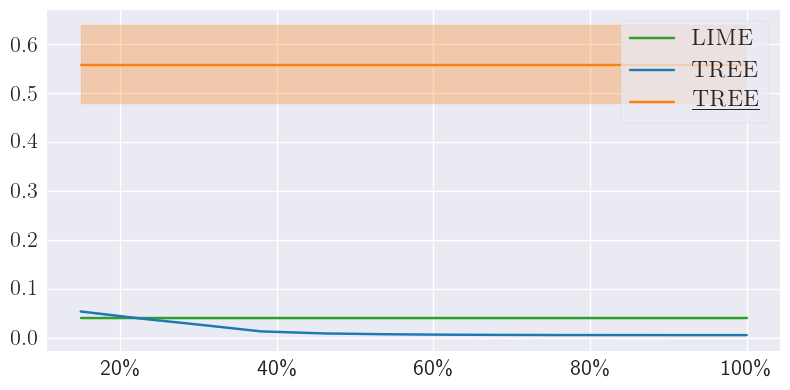

In [15]:
# NBVAL_IGNORE_OUTPUT
plot_loss_summary(lime_scores_summary, limet_scores_summary,
                  1, use_limet_loss=False,
                  use_weighted=True, use_random=False, ignoreR=True)

In [16]:
tabulate_loss_summary(lime_scores_summary, limet_scores_summary, 1,
                      0.33, scale_factor=1, latex=True,
                      use_limet_loss=False, use_weighted=True, use_random=False,
                      ignoreR=True)

\(0.04\pm0.00\)
\(0.02\pm0.00\)
\(0.56\pm0.08\)


{'lime': (0.039168929869771066, 0.0005060462986437124),
 'limet': (0.024877933849679103, 0.00029710172309352535),
 'limetf': (0.5574661433962612, 0.08012015771401519)}